In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family']='Malgun Gothic'

os.getcwd()

'C:\\Users\\samsung\\Desktop\\ml_team'

In [5]:
os.chdir('./ml_team/data/test')
os.listdir()

['2030여성',
 '2030여성.zip',
 '20대초반남성.csv',
 'ALL_chol',
 'cho_test_결과있는사람',
 'cluster_result.csv',
 'cluster_result_not_cholesterol.csv',
 'data.CSV',
 'data2021.CSV',
 'data2022.CSV',
 'df_ord_gpt.csv',
 'df_ord_KPrototypes.csv',
 'kmeans_2030female_pipeline.pkl',
 'my_model.pkl',
 'new_new_cluster_pipeline4.pkl',
 'new_new_cluster_pipeline5.pkl',
 'new_new_new_콜레스테롤_결과있는사람2.pkl',
 'new_new_new_콜레스테롤_결과있는사람3.pkl',
 'new_콜레스테롤_결과있는사람.pkl',
 'not_chol_model.pkl',
 'real_chol_model.pkl',
 'real_cluster.csv',
 'X.csv',
 '국민건강보험공단_건강검진정보 사용자 매뉴얼_2023.hwpx',
 '생활패턴유형_소비지표.xlsx',
 '이상지질검사미수검자건강군집해석.csv',
 '이상지질검사미수검자군집분석_last.csv',
 '이상지질검사수검자군집결과마지막결과.csv',
 '지질검사대상인데기록없는사람',
 '콜레스테롤검사한사람.csv',
 '콜레스테롤측정안한데이터.csv',
 '콜레스테롤측정안한사람.csv',
 '클러스터링_모델_dict.pkl',
 '클러스터링_파이프라인.pkl']

In [7]:
df = pd.read_csv(os.listdir()[7], encoding='cp949') 

In [8]:
df=df[[ '성별코드', '연령대코드(5세단위)', '신장(5cm단위)',
       '체중(5kg단위)', '허리둘레',  '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피', '흡연상태',
       '음주여부']]

In [9]:
cond = df[['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤']].isna().any(axis=1)
df = df[cond]

In [10]:
cond = df['성별코드']==2
df = df[cond]

In [11]:
df.shape

(332590, 20)

In [12]:
df = df.drop(columns=['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤'])
df=df.dropna()

df.shape

(326107, 16)

In [13]:
df.columns=['성별', '연령대', '키', '체중', '허리둘레', '수축기혈압', '이완기혈압', '공복혈당',
            '혈색소', '요단백', '혈청크레아티닌',
       '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피', '흡연상태', '음주여부']

df['성별'] = df['성별'].map({1:0, 2:1})

In [14]:
pd.crosstab(index=df['성별'], columns=df['연령대'])

연령대,5,6,7,8,9,10,11,12,13,14,15,16,17,18
성별,,,,,,,,,,,,,,
1,19511,33672,39122,29235,22973,26075,44532,32368,26243,21433,19704,5851,3566,1822


In [15]:
# bmi추가
# 파생변수 bmi 생성 :  질병관리청 근거
def bmi_category(bmi):
    if bmi < 18.5:
        return 1 #'저체중'
    elif bmi < 23:
        return 2 #'정상'
    elif bmi < 25:
        return 3 #'비만전단계'
    elif bmi < 30:
        return 4 #'비만1단계'
    elif bmi < 35:
        return 5 #'비만2단계'
    else:
        return 6 #'비만3단계'

df['BMI'] = df['체중'] / ((df['키'] / 100) ** 2)
df['BMI구분'] = df['BMI'].apply(bmi_category)
#df = df.drop(columns='BMI',axis=1)

# 입력오류 추정 인스턴스 삭제
cond1= df['허리둘레']==999

df = df.drop(index=df[cond1].index, axis=0).reset_index(drop=True)

# 값이 하나 뚝 떨어져있어서 제외
cond2= df['혈청크레아티닌']==25.0
df = df.drop(index=df[cond1|cond2].index, axis=0).reset_index(drop=True)

# 연령대 그룹 코드별 중앙 나이 추정값 매핑
연령대_중앙값 = {
    1: 2, 2: 7, 3: 12, 4: 17, 5: 22,
    6: 27, 7: 32, 8: 37, 9: 42,
    10: 47, 11: 52, 12: 57, 13: 62,
    14: 67, 15: 72, 16: 77, 17: 82, 18: 87
}

def 사구체여과율(row):
    creatinine = row['혈청크레아티닌']
    group_code = row['연령대']

    # 연령대 매핑 확인
    if group_code not in 연령대_중앙값:
        return np.nan  # 알 수 없는 연령대면 NaN

    age = 연령대_중앙값[group_code]
    sex_factor = 0.742 if row['성별'] == 1 else 1  # 여성=1, 남성=0

    # MDRD 공식 계산
    egfr = 186 * (creatinine ** -1.154) * (age ** -0.203) * sex_factor
    return egfr

df['사구체여과율']= df.apply(사구체여과율, axis=1)


def 신장질환판단(row):
    gap = row['사구체여과율']
    if gap>=90: return '정상'
    elif gap>=60: return '신장기능 감소 시작'
    elif gap>=30: return '신장기능이 더욱 감소' 
    elif gap>=15: return '생명만 유지할 수준' 
    else : return '신장 이식 필요'
df['신장질환군']=df.apply(신장질환판단, axis=1)
df['신장질환군'].value_counts()
# [정상, 신장기능 감소 시작,신장기능이 더욱 감소,생명만 유지할 수준,신장 이식 필요]

# 신장질환은 사구체여과율, 요단백, 혈청크레아티닌 근거로 함
# 요단백은  전날 고지방식 육식, 고당질의 음식 등 식이적인 요인과 격렬한 운동, 급격한 스트레스 등으로 인해서도 양성반응을 보일 수 있으므로 제외함
# 요단백은 변수가 크다고 판단하였음

def 간질환판단(row):
    ast = row['혈청지오티(AST)']
    alt = row['혈청지피티(ALT)']
    gtp = row['감마지티피']

    # 간 효소 중 1개라도 정상 범위 초과 시 간기능 이상 의심
    if ast >= 40 or alt >= 40 or gtp > (63 if row['성별'] == 0 else 35):
        return 1  # 이상
    else:
        return 0  # 정상
        
df['간질환군']=df.apply(간질환판단, axis=1)
df['간질환군'].value_counts()

# 보건소 근거
# 고혈압 합병증 : 뇌, 신장, 눈, 심

def 혈압판단(row):
    수축기 = row['수축기혈압']
    이완기 = row['이완기혈압']

    if 수축기 >= 140 or 이완기 >= 90:
        return '고혈압 의심'
    elif 수축기 >= 120 or 이완기 >= 80:
        return '고혈압 전단계'
    else:
        return '정상 혈압'

df['고혈압군'] = df.apply(혈압판단, axis=1)
df['고혈압군'].value_counts()

def 빈혈판단(row):
    hb = row['혈색소']
    gender = row['성별']

    if gender == 0:
        return 0 if 16.5>=hb >= 13 else 1
    elif gender == 1:
        return 0 if 15.5>=hb >= 12 else 1
    else:
        return '성별 오류'
df['빈혈군'] = df.apply(빈혈판단, axis=1)
df['빈혈군'].value_counts()

def 당뇨판단(row):
    혈당 = row['공복혈당']
    if 혈당>=126: return '당뇨병 의심'
    if 혈당 >= 100: return '공복혈당장애 의심'
    else : return '정상혈당'

df['당뇨군'] = df.apply(당뇨판단, axis=1)
df['당뇨군'].value_counts()

# #['정상혈당','공복혈당장애 의심','당뇨병 의심']

# def 이상지질혈증판단(row):
#     if (
#         row['총콜레스테롤'] > 250 or
#         row['총콜레스테롤'] < 150 or
#         row['HDL콜레스테롤'] > 65 or
#         row['HDL콜레스테롤'] < 30  or
#         row['트리글리세라이드'] > 135 or
#         row['트리글리세라이드'] < 30 or
#         row['LDL콜레스테롤'] >= 170
#     ):
#         return 1  # 이상지질혈증 의심
#     else:
#         return 0  # 정상

# df['이상지질혈증군'] = df.apply(이상지질혈증판단, axis=1)
# df['이상지질혈증군'].value_counts()

def categorize_age(age):
    if age in [5, 6]:
        return '20대'
    elif age in [7, 8]:
        return '30대'
    elif age in [9, 10]:
        return '40대'
    elif age in [11, 12]:
        return '50대'
    elif age in [1, 2, 3, 4]:
        return '미성년자'
    else:
        return '60대이상'

df['연령대'] = df['연령대'].map(categorize_age)

# 허리둘레 480cm 제거 -> 최댓값 160cm
# 공복혈당 500, 600은 당뇨 환자에게 관측되는 수치로 700 이상 제거
cond1 = df['허리둘레'] == 480
cond2 = df['공복혈당'] > 700
cond3 = df['혈청크레아티닌'] > 350
cond4 = df['혈청지오티(AST)'] > 3000
cond5 = df['혈청지피티(ALT)'] > 5000
cond6 = df['감마지티피'] > 8000

# 콜레스테롤 측정 안 된 집단과 공통된 기준 또는 분포에서 너무 떨어진 값만 제거 

df = df[~(cond1 | cond2 | cond3 | cond4 | cond5 | cond6)]


In [16]:
df = df.drop(columns='성별')

In [17]:
scale_col = []
for col in df.columns:
    if df[col].nunique()<20:
        if df[col].nunique() >2:
            scale_col.append(col)
        print(col,':',df[col].unique())
    else : scale_col.append(col)

연령대 : ['20대' '60대이상' '30대' '40대' '50대']
키 : [170 155 150 165 160 145 180 140 175 135 130 185]
요단백 : [1. 2. 5. 3. 4. 6.]
흡연상태 : [1. 3. 2.]
음주여부 : [1. 0.]
BMI구분 : [1 2 4 3 5 6]
신장질환군 : ['정상' '신장기능 감소 시작' '신장기능이 더욱 감소' '생명만 유지할 수준' '신장 이식 필요']
간질환군 : [0 1]
고혈압군 : ['정상 혈압' '고혈압 전단계' '고혈압 의심']
빈혈군 : [0 1]
당뇨군 : ['정상혈당' '공복혈당장애 의심' '당뇨병 의심']


In [18]:
from sklearn.preprocessing import OrdinalEncoder

# 인코딩 대상 컬럼
ordinal_cols = ['연령대', '요단백', '흡연상태', 'BMI구분', '신장질환군', '고혈압군', '당뇨군']

ordinal_categories = [
    ['20대', '30대', '40대', '50대', '60대이상'],                        # 연령대
    [1., 2., 3., 4., 5., 6.],                                           # 요단백
    [1., 2., 3.],                                                       # 흡연상태
    [1, 2, 3, 4, 5, 6],                                                 # BMI구분
    ['정상', '신장기능 감소 시작', '신장기능이 더욱 감소', '생명만 유지할 수준', '신장 이식 필요'],  # 신장질환군
    ['정상 혈압', '고혈압 전단계', '고혈압 의심'],                         # 고혈압군
    ['정상혈당', '공복혈당장애 의심', '당뇨병 의심']                       # 당뇨군
]

# 오디너리 인코더 적용
encoder = OrdinalEncoder(categories=ordinal_categories)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[scale_col] = scaler.fit_transform(df[scale_col])
df.head()

,연령대,키,체중,허리둘레,수축기혈압,이완기혈압,공복혈당,혈색소,요단백,혈청크레아티닌,...,흡연상태,음주여부,BMI,BMI구분,사구체여과율,신장질환군,간질환군,고혈압군,빈혈군,당뇨군
0,-1.532028,2.109265,-0.613522,-0.644416,-1.821253,-1.262593,-0.187332,-0.870193,-0.271044,-0.484241,...,-0.276347,1.0,-1.414891,-1.486999,1.165679,-0.676853,0,-0.870726,0,-0.599339
1,-1.532028,-0.236452,-0.135476,-0.120679,-0.680254,-0.566094,-0.343133,0.462482,-0.271044,-0.484241,...,-0.276347,1.0,-0.035860,-0.579463,0.962581,-0.676853,0,-0.870726,0,-0.599339
2,1.276176,-1.018357,-0.613522,-0.060248,-0.613136,-0.267594,-0.758602,1.173242,-0.271044,-0.484241,...,-0.276347,0.0,-0.201241,-0.579463,0.219635,-0.676853,0,-0.870726,0,-0.599339
3,1.276176,-1.018357,-0.613522,0.463488,-0.613136,-1.262593,-0.498934,-1.225573,-0.271044,-0.018544,...,-0.276347,0.0,-0.201241,-0.579463,-0.540139,1.183110,0,-0.870726,1,-0.599339
4,-0.829977,-0.236452,1.298664,1.752686,-0.009078,0.926405,-0.447000,-0.781348,-0.271044,-0.484241,...,-0.276347,1.0,1.503894,1.235611,0.666141,-0.676853,0,0.627856,0,-0.599339


In [26]:
col=['연령대', '허리둘레', '수축기혈압','공복혈당',
        '혈청크레아티닌',
       '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피', '흡연상태', '음주여부', 'BMI'
     #, 'BMI구분',
      , '사구체여과율']
df1=df[col]

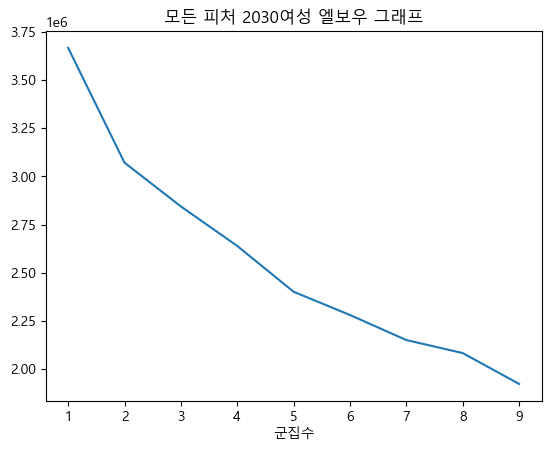

In [27]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA

# PCA (2차원으로 줄이기)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

# ▶ 5. KMeans 클러스터링 (클러스터 수는 예시로 3개)
hy=[]
end=10
for i in range(1,end):
    m=KMeans(n_clusters=i, random_state=42)
    m.fit(df1)
    hy.append(m.inertia_)

plt.title('모든 피처 2030여성 엘보우 그래프')
plt.xlabel('군집수')
plt.plot(range(1,end), hy)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
for i in range(2, 6):
    m1 = KMeans(i, random_state=42).fit(df)
    print(i,':', silhouette_score(X_pca, m1.labels_)) 

2 : 0.3799570000514332
3 : 0.2297113786914887



KeyboardInterrupt



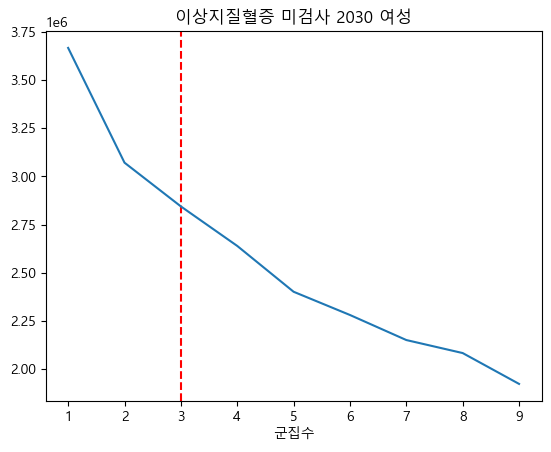

In [29]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA

# PCA (2차원으로 줄이기)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df1)

# ▶ 5. KMeans 클러스터링 (클러스터 수는 예시로 3개)
hy=[]
end=10
for i in range(1,end):
    m=KMeans(n_clusters=i, random_state=42)
    m.fit(df1)
    hy.append(m.inertia_)

plt.title('이상지질혈증 미검사 2030 여성')
plt.xlabel('군집수')
plt.axvline(3, color='red', linestyle='--')
plt.plot(range(1,end), hy)
plt.show()

In [33]:
from sklearn.metrics import silhouette_score, silhouette_samples
for i in range(2, 6):
    m1 = KMeans(i, random_state=42).fit(df1)
    print(i,':', silhouette_score(X_pca, m1.labels_)) 

2 : 0.4255143583424594
3 : 0.4305450358170975
4 : 0.26526110629147914
5 : 0.1784646908405579


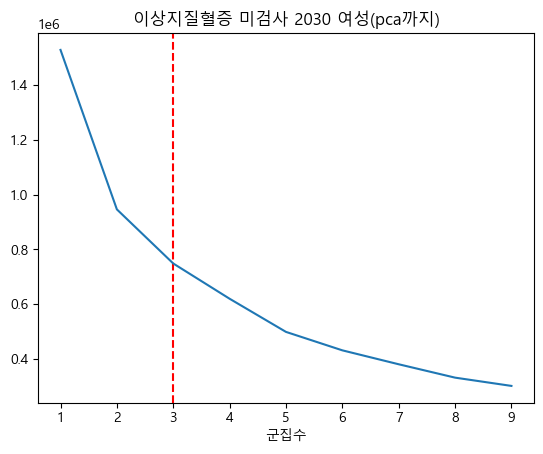

In [30]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA

# PCA (2차원으로 줄이기)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df1)

# ▶ 5. KMeans 클러스터링 (클러스터 수는 예시로 3개)
hy=[]
end=10
for i in range(1,end):
    m=KMeans(n_clusters=i, random_state=42)
    m.fit(X_pca)
    hy.append(m.inertia_)

plt.title('이상지질혈증 미검사 2030 여성(pca까지)')
plt.xlabel('군집수')
plt.axvline(3, color='red', linestyle='--')
plt.plot(range(1,end), hy)
plt.show()

In [23]:
from sklearn.metrics import silhouette_score, silhouette_samples
for i in range(2, 6):
    m1 = KMeans(i, random_state=42).fit(X_pca)
    print(i,':', silhouette_score(X_pca, m1.labels_)) 

2 : 0.4340748660150134
3 : 0.43934896157086817
4 : 0.3560190545696868
5 : 0.35964069220810213


In [24]:
df['연령대'].value_counts()

연령대
 1.276176    78619
 0.574125    76899
-0.829977    68352
-1.532028    53182
-0.127926    49048
Name: count, dtype: int64

In [87]:
m1 = KMeans(3, random_state=42).fit(X_pca)

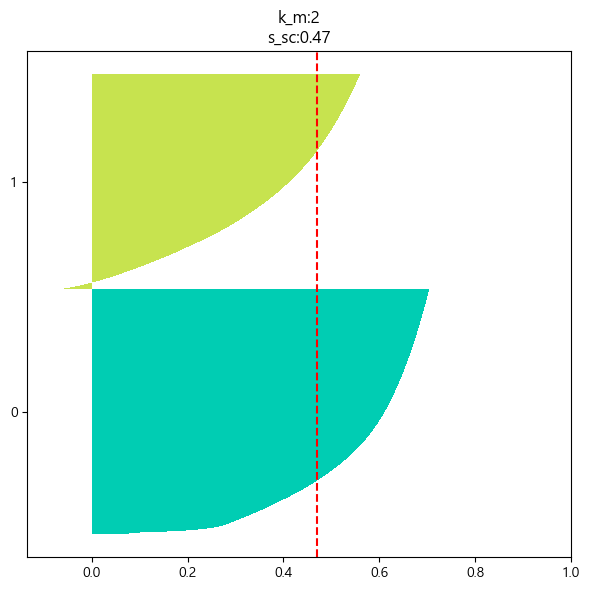

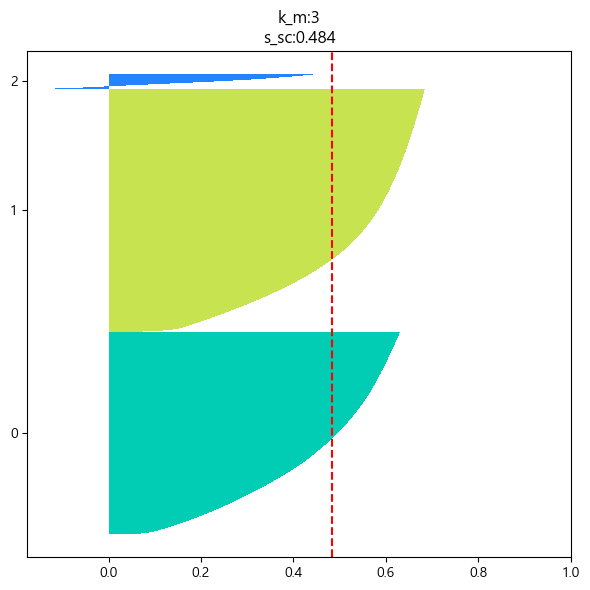

In [90]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# iM 컬러 팔레트
im_colors = ['#00CDB3', '#C7E34F', '#2484FF', '#A15EFF', '#91DAFF', '#F5E8D7', '#9EA4AA']

# 실루엣 계수 시각화 함수
def c_s(k, df1):
    # 1. PCA로 차원 축소
    pca = PCA(n_components=2)
    x_f = pca.fit_transform(df1)

    # 2. KMeans 모델 적합
    km = KMeans(n_clusters=k, random_state=10)
    py = km.fit_predict(x_f)

    # 3. 실루엣 계수 계산
    s_v = silhouette_samples(x_f, py)

    # 4. 시각화
    y_ax_lo = 0
    y_t = []

    plt.figure(figsize=(6, 6))

    for i in range(k):
        c_s_v = s_v[py == i]
        c_s_v.sort()
        y_ax_up = y_ax_lo + len(c_s_v)

        # iM뱅크 색 적용
        color = im_colors[i % len(im_colors)]

        plt.barh(range(y_ax_lo, y_ax_up), c_s_v, height=1, color=color)
        y_t.append((y_ax_lo + y_ax_up) / 2.)
        y_ax_lo = y_ax_up

    s_mean = np.mean(s_v)
    plt.axvline(s_mean, color='red', linestyle='--')
    plt.yticks(y_t, range(k))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(f'k_m:{k}\ns_sc:{round(s_mean, 3)}')
    plt.tight_layout()
    plt.show()

# 예시 실행
c_s(2, df1)
c_s(3, df1)

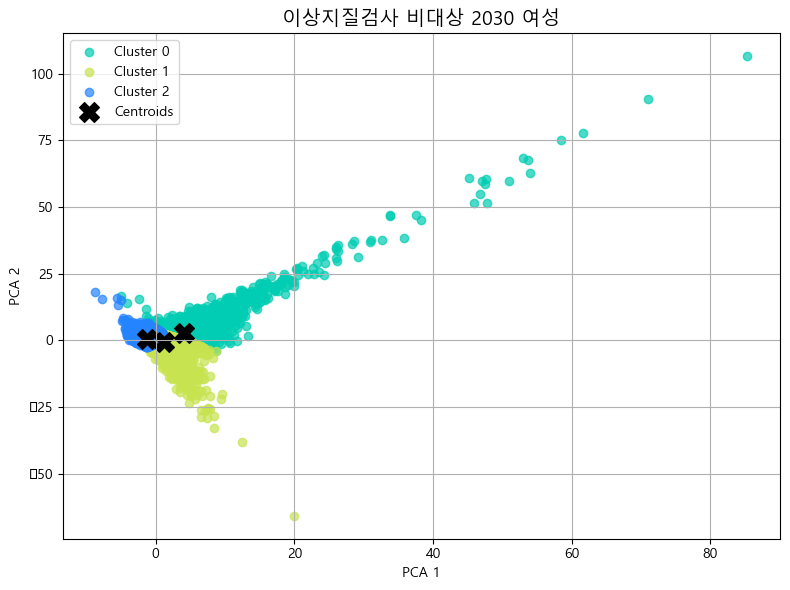

In [89]:
import matplotlib.pyplot as plt

# iM뱅크 색상 팔레트
im_colors = ['#00CDB3', '#C7E34F', '#2484FF', '#A15EFF', '#91DAFF', '#F5E8D7', '#9EA4AA']

# 1. 군집 결과 컬럼 추가 (이미 있다면 생략 가능)
df1['cluster'] = m1.labels_

# 2. 시각화 시작
plt.figure(figsize=(8, 6))

# 3. 군집별 색상 적용 및 시각화
for cluster in sorted(df1['cluster'].unique()):
    plt.scatter(
        X_pca[df1['cluster'] == cluster, 0],  # PCA 첫 번째 성분
        X_pca[df1['cluster'] == cluster, 1],  # PCA 두 번째 성분
        label=f'Cluster {cluster}',
        alpha=0.7,
        color=im_colors[cluster % len(im_colors)]
    )

# 4. 군집 중심 (Centroids) 시각화
centers = m1.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='black', s=200, marker='X', label='Centroids'
)

# 5. 스타일 마무리
plt.title('이상지질검사 비대상 2030 여성', fontsize=14)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()